In [1]:
## personal imports
from processor.processor import Processor as p
from database.market import Market
from database.adatabase import ADatabase
from datetime import datetime
from fund.fund import Fund
from pricer.pricer import Pricer as pricer_list
from ranker.ranker import Ranker as ranker_list
from classifier.classifier import Classifier as classifier_list
from portfolio.aportfolio import APortfolio

from analysis.quarterly_analysis import QuarterlyAnalysis as quarterly_analysis
from analysis.weekly_analysis import WeeklyAnalysis as weekly_analysis

## risk and return class imports
from returns.products import Products as returns_products_class


from fund.fund import Fund
## standard imports
from statistics import variance
import math
from datetime import datetime, timedelta
import pytz
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
backtest_start_date = datetime(2016,1,1)
backtest_end_date  = datetime(2023,1,1)
current_start_date = datetime(2023,1,1)

In [3]:
market = Market()

In [4]:
portfolio = APortfolio(pricer_list.QUARTERLY_STOCK_FINANCIAL
                       ,classifier_list.QUARTERLY_STOCK_FINANCIAL_CLASSIFIER
                       ,ranker_list.QUARTERLY_STOCK_EARNINGS_RANKER)
portfolio_ii = APortfolio(pricer_list.WEEKLY_STOCK_SPECULATION
                          ,classifier_list.WEEKLY_STOCK_SPECULATION_CLASSIFIER
                          ,ranker_list.WEEKLY_STOCK_ROLLING_RANKER)
portfolio_iii = APortfolio(pricer_list.WEEKLY_STOCK_ROLLING
                           ,classifier_list.WEEKLY_STOCK_SPECULATION_CLASSIFIER
                          ,ranker_list.WEEKLY_STOCK_ROLLING_RANKER)
portfolio_iv = APortfolio(pricer_list.WEEKLY_STOCK_WINDOW
                          ,classifier_list.WEEKLY_STOCK_SPECULATION_CLASSIFIER
                          ,ranker_list.WEEKLY_STOCK_ROLLING_RANKER)
portfolios = [portfolio_ii,portfolio_iii,portfolio_iv]
fund = Fund(portfolios,backtest_start_date,backtest_end_date,current_start_date)
fund.initialize_portfolios()

In [5]:
market.connect()
sp500 = market.retrieve("sp500")
market.disconnect()
sp500 = sp500.rename(columns={"Symbol":"ticker"})

In [6]:
tyields = returns_products_class.tyields()
bench_returns = returns_products_class.spy_bench()

In [7]:
trades = []
for portfolio in fund.portfolios:
    portfolio.db.connect()
    trade = portfolio.db.retrieve("historical_trades")
    trade["positions"] = portfolio.pricer_class.positions
    trade["portfolio"] = portfolio.name
    trade["pricer_timeframe"] = portfolio.pricer_class.time_horizon_class.naming_convention
    trades.append(trade)
    portfolio.db.disconnect()

In [8]:
t = pd.concat(trades)

In [9]:
t

,year,week,ticker,weekly_delta,weekly_delta_sign,returns,position,actual_returns,value,ceiling,classification,rank,positions,portfolio,pricer_timeframe
0,2016,3,VLO,0.033761,-1.0,0.993621,0,0.993621,True,True,True,True,10,wss_wssc_wsrr_b_r,week
1,2016,21,DISH,0.036213,1.0,1.067023,0,1.067023,True,True,True,True,10,wss_wssc_wsrr_b_r,week
2,2016,27,EBAY,0.017858,1.0,1.040792,0,1.040792,True,True,True,True,10,wss_wssc_wsrr_b_r,week
3,2016,31,CVX,0.021756,-1.0,0.995468,0,0.995468,True,True,True,True,10,wss_wssc_wsrr_b_r,week
4,2016,34,VZ,0.023028,-1.0,1.002835,0,1.002835,True,True,True,True,10,wss_wssc_wsrr_b_r,week
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28267,2022,48,CSCO,0.082767,-1.0,1.008705,9,1.008705,False,False,False,False,10,wsw_wssc_wsrr_b_r,week
28268,2022,49,FANG,0.114406,1.0,1.005173,9,1.005173,False,False,False,False,10,wsw_wssc_wsrr_b_r,week
28269,2022,50,LHX,0.048459,1.0,0.969208,9,0.969208,False,False,False,False,10,wsw_wssc_wsrr_b_r,week
28270,2022,51,WDC,0.112064,1.0,0.995411,9,0.995411,False,False,False,False,10,wsw_wssc_wsrr_b_r,week


In [10]:
nonindex_columns = [
"year"
,"quarter"
,"week"
,"ticker"
,"quarterly_delta_sign"
,"quarterly_delta"
,"weekly_delta_sign"
,"weekly_delta"
,"returns"
,"floored_returns"
,"actual_returns"
,"position"
,"projected_quarterly_return"
,"positions"] 

In [11]:
indexers = []
indexer = []
for col in t.columns:
    if col not in nonindex_columns:
        indexers.append(list(t[col].unique()))
        indexer.append(col)
stuff = t[indexer].to_dict("records")
parameters = [dict(t) for t in {tuple(d.items()) for d in stuff}]

In [12]:
indexer

['value', 'ceiling', 'classification', 'rank', 'portfolio', 'pricer_timeframe']

In [13]:
analysis = []
for parameter in parameters:
    try:
        ledger = t.sort_values(["year",parameter["pricer_timeframe"]]).copy()
        for key in parameter.keys():
            ledger = ledger[ledger[key]==parameter[key]]
        positions = int(ledger["positions"].mean())
        anas = weekly_analysis if parameter["pricer_timeframe"] == "week" else quarterly_analysis
        if ledger.index.size > 0:
            cumulative = anas.trade_analysis(indexer,ledger,positions,parameter,tyields,bench_returns)
            analysis.append(cumulative[indexer + ["pv","beta","rrr","sharpe"]].iloc[-1])
    except Exception as e:
        print(str(e))
        continue
a = pd.DataFrame(analysis)

In [14]:
a.sort_values("pv",ascending=False).groupby("portfolio").first().reset_index()

,portfolio,value,ceiling,classification,rank,pricer_timeframe,pv,beta,rrr,sharpe
0,wsr_wssc_wsrr_b_r,True,False,False,False,week,5.387869,0.000983,1.064290,35.385278
1,wss_wssc_wsrr_b_r,True,False,False,False,week,11.889722,0.018311,1.045365,2.064320
2,wsw_wssc_wsrr_b_r,True,False,False,False,week,11.281162,0.048470,1.047565,0.872747


In [15]:
top = a[a["portfolio"]=="wss_wssc_wsrr_b_r"].sort_values("pv",ascending=False).iloc[0]
anas = weekly_analysis if top["pricer_timeframe"] == "week" else quarterly_analysis
analysis = t
for key in parameter.keys():
    analysis = analysis[(analysis[key]==top[key])]
naming = top["pricer_timeframe"]
ledger = analysis[["year",naming,"ticker",f"{naming}ly_delta",f"{naming}ly_delta_sign","actual_returns","position"]]
ledger = ledger.merge(sp500[["ticker","GICS Sector","Security"]],on="ticker",how="left")

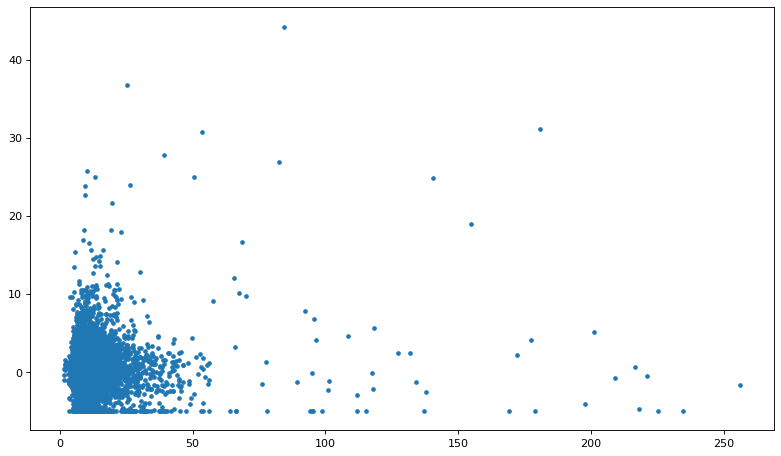

In [16]:
plt.figure(figsize=(12, 7), dpi=80)
plt.scatter(ledger[f"{naming}ly_delta"] * 100, (ledger["actual_returns"]-1)*100,s=10)

In [17]:
ledger.sort_values(["year",naming,"position"],ascending=True).head(20)

,year,week,ticker,weekly_delta,weekly_delta_sign,actual_returns,position,GICS Sector,Security
0,2016,2,FCX,0.762711,-1.0,0.984677,0,Materials,Freeport-McMoRan
358,2016,2,WMB,0.384988,-1.0,0.954605,1,Energy,Williams Companies
716,2016,2,HWM,0.214633,-1.0,1.025827,2,Industrials,Howmet Aerospace
1074,2016,2,WYNN,0.180532,-1.0,0.951624,3,Consumer Discretionary,Wynn Resorts
1432,2016,2,MCK,0.172547,-1.0,0.970279,4,Health Care,McKesson
1790,2016,2,CMG,0.160675,-1.0,0.954537,5,Consumer Discretionary,Chipotle Mexican Grill
2148,2016,2,HES,0.149587,-1.0,1.034721,6,Energy,Hess Corporation
2506,2016,2,NRG,0.139426,-1.0,1.015002,7,Utilities,NRG Energy
2863,2016,2,CSX,0.116080,-1.0,1.019115,8,Industrials,CSX
3220,2016,2,ANET,0.115565,-1.0,1.019231,9,Information Technology,Arista Networks


In [18]:
portfolio = ledger.pivot_table(index=["year",naming],columns="position",values="actual_returns").fillna(1).reset_index()

In [19]:
portfolio

position,year,week,0,1,2,3,4,5,6,7,8,9
0,2016,2,0.984677,0.954605,1.025827,0.951624,0.970279,0.954537,1.034721,1.015002,1.019115,1.019231
1,2016,3,0.950000,0.950000,0.973775,1.018519,1.017939,1.001043,0.997240,0.995601,1.027726,0.999107
2,2016,4,0.950000,0.971186,0.979986,1.030868,0.994162,0.986275,0.968940,1.032544,1.084124,1.001052
3,2016,5,1.054109,1.093580,1.041282,1.070175,1.104799,1.024068,0.971731,1.074623,1.052693,0.984934
4,2016,6,0.950000,0.950000,0.986668,0.957292,0.956063,1.005927,0.950000,0.982397,0.950000,0.950000
...,...,...,...,...,...,...,...,...,...,...,...,...
353,2022,48,1.010056,1.003763,1.022404,1.019786,0.998926,1.021503,1.061735,0.974639,0.988058,1.050996
354,2022,49,0.976360,1.012846,0.989232,0.992456,1.010472,1.045423,0.995533,0.989193,0.989806,0.992224
355,2022,50,0.987461,1.096941,1.006841,0.989064,0.989299,1.017643,1.002509,0.999050,1.032219,1.006135
356,2022,51,1.006106,1.059169,0.988272,0.985589,1.053452,1.014511,1.043318,1.004589,1.005748,1.027147


In [20]:
cumulative = anas.iteration_analysis(portfolio,positions,bench_returns)

In [21]:
cumulative

,0,1,2,3,4,5,6,7,8,9,date_string,date,pv,adjclose,bench
0,0.984677,0.954605,1.025827,0.951624,0.970279,0.954537,1.034721,1.015002,1.019115,1.019231,2016-W2,2016-01-15,0.992962,187.8100,1.000000
1,0.935443,0.906875,0.998924,0.969246,0.987684,0.955532,1.031865,1.010537,1.047371,1.018321,2016-W3,2016-01-22,0.986180,190.5200,1.014429
2,0.888671,0.880744,0.978932,0.999165,0.981918,0.942418,0.999816,1.043424,1.135480,1.019392,2016-W4,2016-01-29,0.986996,193.7208,1.031472
3,0.936755,0.963165,1.019345,1.069281,1.084822,0.965099,0.971552,1.121288,1.195312,1.004034,2016-W5,2016-02-05,1.033065,187.9500,1.000745
4,0.889918,0.915006,1.005755,1.023614,1.037158,0.970820,0.922975,1.101550,1.135546,0.953832,2016-W6,2016-02-12,0.995617,186.6300,0.993717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353,2.201909,3.369003,15.021518,12.138523,9.451673,10.791068,10.348637,18.580761,25.844639,8.865515,2022-W48,2022-12-02,11.661325,406.9100,2.166605
354,2.149857,3.412280,14.859761,12.046954,9.550651,11.281229,10.302414,18.379956,25.581185,8.796580,2022-W49,2022-12-09,11.636087,393.2800,2.094031
355,2.122899,3.743069,14.961421,11.915212,9.448449,11.480260,10.328268,18.362501,26.405380,8.850550,2022-W50,2022-12-16,11.761801,383.2700,2.040733
356,2.135862,3.964542,14.785950,11.743504,9.953492,11.646844,10.775667,18.446765,26.557152,9.090818,2022-W51,2022-12-23,11.910060,382.9100,2.038816


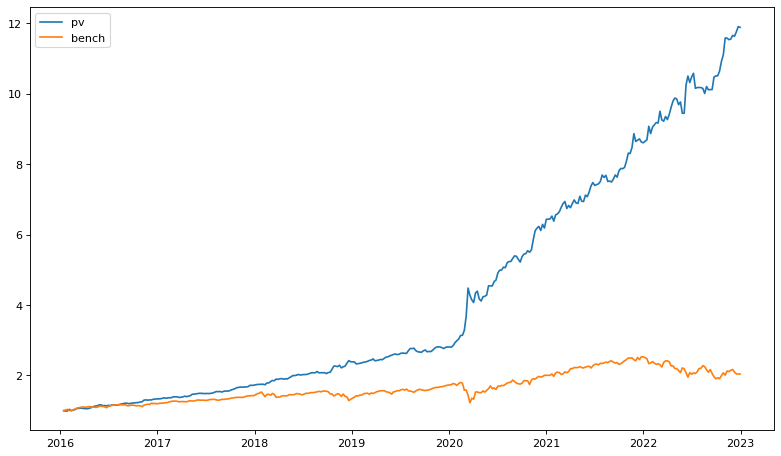

In [22]:
plt.figure(figsize=(12, 7), dpi=80)
plt.plot(cumulative["date"],cumulative["pv"])
plt.plot(cumulative["date"],cumulative["bench"])
plt.legend(["pv","bench"])

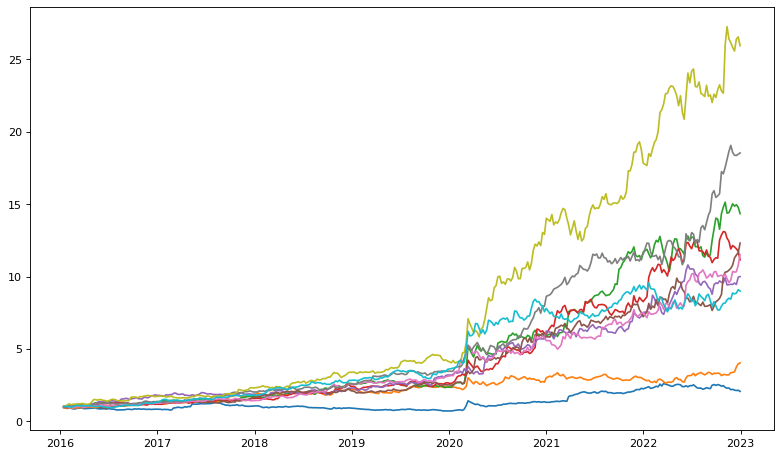

In [23]:
plt.figure(figsize=(12, 7), dpi=80)
position_columns = [x for x in cumulative.columns if x not in ["date_string","date","pv","adjclose","bench"]]
for i in position_columns:
    position = cumulative[i]
    plt.plot(cumulative["date"],position)

plt.show()


In [24]:
ledger.groupby(["GICS Sector"]).mean().sort_values("actual_returns",ascending=False)

,year,week,weekly_delta,weekly_delta_sign,actual_returns,position
GICS Sector,,,,,,
Financials,2018.881720,27.236559,0.104429,-0.043011,1.010851,5.666667
Information Technology,2018.571192,25.973510,0.187680,-0.049669,1.009180,4.536424
Communication Services,2019.583643,28.977695,0.117837,-0.241636,1.008800,4.985130
Energy,2019.592857,26.421429,0.153856,-0.157143,1.007516,5.135714
Health Care,2018.929062,28.771167,0.117642,0.034325,1.007356,4.773455
Industrials,2018.825893,26.000000,0.117679,-0.160714,1.006817,5.401786
Consumer Discretionary,2019.102877,26.827376,0.179749,0.084568,1.005955,3.349608
Materials,2018.679012,24.993827,0.116461,0.012346,1.005085,5.611111
Consumer Staples,2018.706522,24.239130,0.100631,-0.217391,1.003176,5.663043


In [25]:
ledger.groupby(["year",naming,"ticker","Security"]).prod().sort_values("actual_returns",ascending=False).head(30)

weekly_delta  \
year week ticker Security                                       
2020 11   CZR    Caesars Entertainment               0.844167   
     10   NCLH   Norwegian Cruise Line Holdings      0.252935   
     11   APA    APA Corporation                     1.807190   
          CCL    Carnival                            0.536702   
     10   CZR    Caesars Entertainment               0.390798   
     11   RCL    Royal Caribbean Group               0.826197   
     7    ENPH   Enphase                             0.103332   
     11   MPC    Marathon Petroleum                  0.505494   
     48   MRNA   Moderna                             0.132420   
     11   NCLH   Norwegian Cruise Line Holdings      1.404816   
2021 12   PARA   Paramount Global                    0.264336   
2020 20   CZR    Caesars Entertainment               0.094039   
     15   TSLA   Tesla, Inc.                         0.093051   
     10   MPC    Marathon Petroleum                  0.196826   
2017 19   ENPH   Enphase                             1.548580   
2021 12   WBD    Warner Bros. Discovery              0.192753   
2022 23   RCL    Royal Caribbean Group               0.089484   
2020 10   DXC    DXC Technology                      0.228736   
2022 23   CCL    Carnival                            0.086531   
2017 9    ENPH   Enphase                             0.686677   
2020 27   TSLA   Tesla, Inc.                         0.109471   
     8    PARA   Paramount Global                    0.115594   
2022 3    NFLX   Netflix                             0.162297   
2016 38   TWTR   Twitter Inc.                        0.057400   
2020 32   PENN   Penn National Gaming                0.151065   
2022 44   LNC    Lincoln Financial                   0.136939   
     43   META   Meta Platforms                      0.124863   
2018 7    SEDG   SolarEdge                           0.148068   
2020 10   PENN   Penn National Gaming                0.214339   
2016 18   SEDG   SolarEdge                           0.130699   

                                                 weekly_delta_sign  \
year week ticker Security                                            
2020 11   CZR    Caesars Entertainment                        -1.0   
     10   NCLH   Norwegian Cruise Line Holdings               -1.0   
     11   APA    APA Corporation                              -1.0   
          CCL    Carnival                                     -1.0   
     10   CZR    Caesars Entertainment                        -1.0   
     11   RCL    Royal Caribbean Group                        -1.0   
     7    ENPH   Enphase                                       1.0   
     11   MPC    Marathon Petroleum                           -1.0   
     48   MRNA   Moderna                                       1.0   
     11   NCLH   Norwegian Cruise Line Holdings               -1.0   
2021 12   PARA   Paramount Global                             -1.0   
2020 20   CZR    Caesars Entertainment                         1.0   
     15   TSLA   Tesla, Inc.                                   1.0   
     10   MPC    Marathon Petroleum                           -1.0   
2017 19   ENPH   Enphase                                      -1.0   
2021 12   WBD    Warner Bros. Discovery                       -1.0   
2022 23   RCL    Royal Caribbean Group                        -1.0   
2020 10   DXC    DXC Technology                               -1.0   
2022 23   CCL    Carnival                                     -1.0   
2017 9    ENPH   Enphase                                      -1.0   
2020 27   TSLA   Tesla, Inc.                                   1.0   
     8    PARA   Paramount Global                             -1.0   
2022 3    NFLX   Netflix                                      -1.0   
2016 38   TWTR   Twitter Inc.                                  1.0   
2020 32   PENN   Penn National Gaming                          1.0   
2022 44   LNC    Lincoln Financial                            -1.0   
     43 

In [26]:
industry_analysis = ledger.pivot_table(index=["year",naming],columns="GICS Sector",values="actual_returns").fillna(1).reset_index()
industry_analysis[[x for x in industry_analysis.columns if x != "sell_date"]].cumprod()

GICS Sector,year,week,Communication Services,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Real Estate,Utilities
0,2016,2,1.000000,0.953080,1.000000,0.994663,1.000000,0.970279,1.022471,1.019231,0.984677,1.000000,1.015002
1,4064256,6,1.000000,0.956331,1.000000,0.994663,0.998584,0.970279,1.022471,1.010726,0.935443,1.000000,1.015002
2,8193540096,24,1.000000,0.928775,1.000000,0.994663,0.989116,1.000229,1.055746,0.996853,0.934794,1.000000,1.015002
3,16518176833536,120,1.000000,0.949620,1.000000,0.994663,0.989116,1.070420,1.055746,1.080751,0.962631,1.000000,1.015002
4,33300644496408576,720,1.000000,0.905018,1.000000,0.972744,0.989116,1.020802,1.055746,1.039923,0.962631,0.982397,1.015002
...,...,...,...,...,...,...,...,...,...,...,...,...,...
353,0,0,4.192540,5.935305,1.449671,2.230606,3.095693,4.419960,2.700135,15.478159,2.219897,1.135371,1.057465
354,0,0,4.093431,6.004504,1.449671,2.212410,3.236308,4.419960,2.700135,15.311485,2.219897,1.135371,1.057465
355,0,0,4.103703,6.087246,1.448294,2.227546,3.236308,4.562366,2.700135,15.311485,2.259061,1.135371,1.057465
356,0,0,4.128760,6.236347,1.448294,2.227546,3.236308,4.562366,2.715654,15.381749,2.259061,1.135371,1.057465
